# Train/Test the True Relationship Model

This notebook is design to predict DG relationships on the entity level. Here we are taking the input from the Bi-LSTM model, prior probability notebook and the summary statistics notebook and combinging it into a single dataset. From there we train a Ridge LR model and an elastic net LR model to make the final prediction.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from scipy.stats import fisher_exact
import scipy
from sqlalchemy import and_
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
candidate_df = pd.read_csv("disease_gene_summary_stats.csv")
prior_df = pd.read_csv("observation-prior.csv")

In [3]:
candidate_df.head(10)

,disease_id,gene_id,sentence_count,doc_num,odds_ratio,expected_sen,hetnet_labels,avg_marginal,quantile_zero,quantile_twenty,quantile_forty,quantile_sixty,quantile_eighty,lower_ci,nlog10_p_value
0,DOID:12849,3569,38,18,0.617773,62.795531,1,0.747175,0.075081,0.650967,0.907099,0.913931,0.916503,-0.001252,2.072880e-04
1,DOID:3070,567,16,11,0.192395,86.200979,-1,0.130409,0.076953,0.078801,0.081089,0.082576,0.086210,-0.025416,3.315404e-09
2,DOID:1324,6647,28,13,0.142479,194.551269,-1,0.085042,0.074244,0.075985,0.080222,0.084748,0.089595,-0.044854,-4.342945e-11
3,DOID:3121,2353,5,1,2.319352,2.589809,-1,0.080139,0.078177,0.078499,0.079471,0.080457,0.081399,-0.000705,1.315072e+00
4,DOID:10652,5520,3,2,2.601331,1.549830,-1,0.082038,0.077898,0.078693,0.078702,0.082385,0.085898,-0.022814,1.116009e+00
5,DOID:5041,319100,6,2,24.599058,0.301847,-1,0.084278,0.078433,0.081272,0.082851,0.084216,0.086745,0.020276,7.488341e+00
6,DOID:2531,6400,4,1,0.674023,6.909290,-1,0.081141,0.077944,0.079681,0.080332,0.081041,0.081786,-0.102290,6.776874e-02
7,DOID:1936,22846,1,1,1.528825,1.291256,-1,0.087098,0.087098,0.087098,0.087098,0.087098,0.087098,-0.020213,4.202512e-01
8,DOID:2377,10804,2,2,4.934903,0.613036,-1,0.079142,0.077703,0.078278,0.078854,0.079430,0.080006,-0.018946,1.581787e+00
9,DOID:14227,83844,13,8,4841.654246,0.009900,1,0.170588,0.076621,0.079998,0.082054,0.090462,0.151144,0.538260,1.000000e+01


In [4]:
prior_df.head(10)

,disease_id,gene_id,disease_associates,gene_associates,prior_perm,prior_perm_stderr
0,DOID:2531,7124,550,47,0.870898,0.000558
1,DOID:2531,7157,550,46,0.867094,0.000565
2,DOID:2531,5743,550,40,0.830758,0.000624
3,DOID:2531,3569,550,39,0.823473,0.000634
4,DOID:2531,4318,550,37,0.809203,0.000654
5,DOID:2531,3586,550,35,0.793287,0.000674
6,DOID:2531,7422,550,34,0.783978,0.000685
7,DOID:2531,7040,550,33,0.777711,0.000692
8,DOID:2531,3553,550,31,0.758141,0.000712
9,DOID:2531,213,550,30,0.747171,0.000723


# Set up the Training and Testing Set

In [5]:
train_df = pd.read_csv("stratified_data/training_set.csv")
dev_df = pd.read_csv("stratified_data/dev_set.csv")
test_df = pd.read_csv("stratified_data/test_set.csv")

In [6]:
# Gather the summary stats for each candidate
training_set = pd.merge(candidate_df, train_df, how='right', on=["disease_id", "gene_id"])
dev_set = pd.merge(candidate_df, dev_df, how='right', on=["disease_id", "gene_id"])
test_set = pd.merge(candidate_df, test_df, how='right', on=["disease_id", "gene_id"])


# Drop the values that aren't found in pubmed. 
training_set = training_set.drop("hetnet_labels", axis=1)
dev_set = dev_set.drop("hetnet_labels", axis=1)
test_set = test_set.drop("hetnet_labels", axis=1)

training_set = training_set.dropna()
dev_set = dev_set.dropna()
test_set = test_set.dropna()

# Add the prior prob to the different sets 
training_set = pd.merge(training_set, prior_df[["disease_id", "gene_id", "prior_perm"]])
dev_set = pd.merge(dev_set, prior_df[["disease_id", "gene_id", "prior_perm"]])
test_set = pd.merge(test_set, prior_df[["disease_id", "gene_id", "prior_perm"]])

In [7]:
non_features = ["hetnet","final_model_pred", "disease_id", "gene_id", "gene_name", "disease_name", "pubmed"]

X = training_set[[col for col in training_set.columns if col not in non_features]]
Y = training_set["hetnet"]

X_dev = dev_set[[col for col in dev_set.columns if col not in non_features]]
Y_dev = dev_set["hetnet"]

X_test = test_set[[col for col in test_set.columns if col not in non_features]]
Y_test = test_set["hetnet"]

# Train the Machine Learning Algorithms

Here we use gridsearch to optimize both models using 10 fold cross validation. After exhausting the list of parameters, the best model is chosen and analyzed in the next chunk. 

In [8]:
n_iter = 100
final_models = []

lr = LogisticRegression()
lr_grid = {'C':np.linspace(1, 100, num=100)}

In [9]:
%%time

# Train on data without LSTM input
lstm_features = [
    "avg_marginal", "quantile_zero", 
    "quantile_twenty","quantile_forty",
    "quantile_sixty", "quantile_eighty", 
    "lower_ci"
]


tempX = X[[col for col in X.columns if col not in lstm_features]]
tempX = tempX.append(X_dev[[col for col in X_dev.columns if col not in lstm_features]])

final_model = GridSearchCV(lr, lr_grid, cv=10, n_jobs=3, scoring='roc_auc')
final_model.fit(tempX, Y.append(Y_dev))
final_models.append(final_model)

CPU times: user 13 s, sys: 656 ms, total: 13.6 s
Wall time: 5min 36s


In [10]:
%%time

# Train on data with LSTM input
final_model = GridSearchCV(lr, lr_grid, cv=10, n_jobs=3)
final_model.fit(X.append(X_dev), Y.append(Y_dev))
final_models.append(final_model)

CPU times: user 20.9 s, sys: 564 ms, total: 21.5 s
Wall time: 11min 25s


## Parameter Optimization

In [11]:
no_lstm_result = pd.DataFrame(final_models[0].cv_results_)
lstm_result = pd.DataFrame(final_models[1].cv_results_)

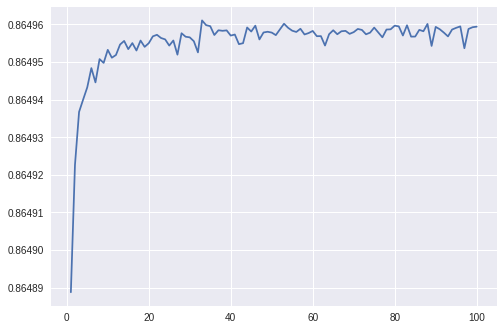

In [12]:
# No LSTM
plt.plot(no_lstm_result['param_C'], no_lstm_result['mean_test_score'])

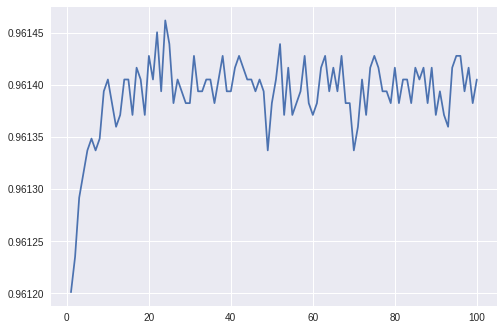

In [13]:
# LSTM
plt.plot(lstm_result['param_C'], lstm_result['mean_test_score'])

## LR Weights

In [14]:
zip(final_models[0].best_estimator_.coef_[0], [col for col in training_set.columns if col not in lstm_features+non_features])

[(0.00039217665289344682, 'sentence_count'),
 (0.0082013204138449702, 'doc_num'),
 (0.00082612773325277031, 'odds_ratio'),
 (-0.0033349921372971599, 'expected_sen'),
 (0.2917372505738754, 'nlog10_p_value'),
 (9.3229064298658049, 'prior_perm')]

In [15]:
zip(final_models[1].best_estimator_.coef_[0], [col for col in training_set.columns if col not in non_features])

[(0.0021391224835676527, 'sentence_count'),
 (-0.0018738106067114624, 'doc_num'),
 (0.00016980255672273815, 'odds_ratio'),
 (-0.0014924808650988079, 'expected_sen'),
 (13.53495468052407, 'avg_marginal'),
 (-3.0983838967912454, 'quantile_zero'),
 (-0.38533223736136801, 'quantile_twenty'),
 (-1.2718465655481976, 'quantile_forty'),
 (-1.4417952329829533, 'quantile_sixty'),
 (-1.312208492526233, 'quantile_eighty'),
 (3.2279232675109815, 'lower_ci'),
 (0.22946380886843337, 'nlog10_p_value'),
 (4.2849547812120159, 'prior_perm')]

# ML Performance

In [16]:
colors = ["green","red"]
labels = ["LR_NO_LSTM","LR_LSTM"]

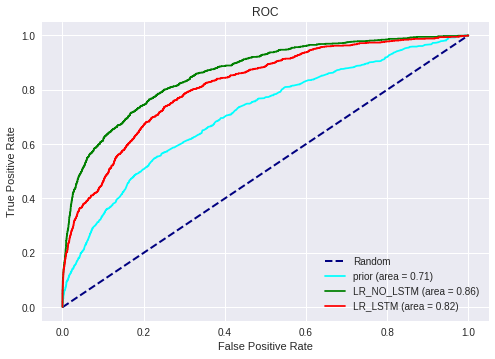

In [17]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

# Plot the p_values log transformed
fpr, tpr, thresholds= roc_curve(Y_test, X_test["prior_perm"])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cyan', label="{} (area = {:0.2f})".format("prior", model_auc))

fpr, tpr, thresholds= roc_curve(Y_test, final_models[0].predict_proba(X_test[[col for col in X.columns if col not in lstm_features]])[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[0], label="{} (area = {:0.2f})".format(labels[0], model_auc))

fpr, tpr, thresholds= roc_curve(Y_test, final_models[1].predict_proba(X_test)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[1], label="{} (area = {:0.2f})".format(labels[1], model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

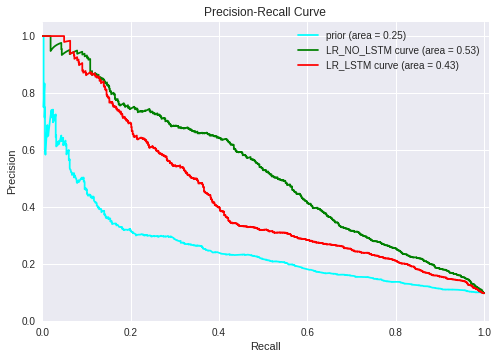

In [18]:
plt.figure()

# Plot the p_values log transformed
precision, recall, _= precision_recall_curve(Y_test, X_test["prior_perm"])
model_precision = average_precision_score(Y_test, X_test["prior_perm"])
plt.plot(recall, precision, color='cyan', label="{} (area = {:0.2f})".format("prior", model_precision))

precision, recall, _ = precision_recall_curve(Y_test, final_models[0].predict_proba(X_test[[col for col in X.columns if col not in lstm_features]])[:,1])
model_precision = average_precision_score(Y_test, final_models[0].predict_proba(X_test[[col for col in X.columns if col not in lstm_features]])[:,1])
plt.plot(recall, precision, color=colors[0], label="{} curve (area = {:0.2f})".format(labels[0], model_precision))
  
precision, recall, _ = precision_recall_curve(Y_test, final_models[1].predict_proba(X_test)[:,1])
model_precision = average_precision_score(Y_test, final_models[1].predict_proba(X_test)[:,1])
plt.plot(recall, precision, color=colors[1], label="{} curve (area = {:0.2f})".format(labels[1], model_precision))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="upper right")

## Save Final Result in DF

In [19]:
predictions = final_models[1].predict_proba(X_test[[col for col in training_set.columns if col not in ["hetnet","final_model_pred", "disease_id", "gene_id", "gene_name", "disease_name", "pubmed"]]])
predictions_df = pd.DataFrame([], columns=["predictions"])
predictions_df["predictions"] = predictions[:,1]

In [20]:
predictions_df.to_csv("final_model_predictions.csv", index=False)